In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy import signal
from scipy.interpolate import interp1d
from scipy.linalg import hankel

import math

In [79]:
### ====  1. Load the raw data ============

datadir = 'data_RGCs/'
stim = np.squeeze(loadmat(f'{datadir}Stim.mat')['Stim']) # contains stimulus value at each frame
stim_times = np.squeeze(loadmat(f'{datadir}stimtimes.mat')['stimtimes']) # contains time in seconds at each frame (120 Hz)
all_spike_times = [np.squeeze(x) for x in np.squeeze(loadmat(f'{datadir}SpTimes.mat')['SpTimes'])] # time of spikes for 4 neurons (in units of stim frames)
num_cells = len(all_spike_times)

print(f'length of stimulus: {stim.shape}')
print(f'Number of spikes for each of 4 neurons: {" ".join([str(x.size) for x in all_spike_times])}')

# Compute some basic statistics on the stimulus
dt_stim = stim_times[1] - stim_times[0] # time bin size

# Pick a cell to work with
cell_idx = 2
spike_times = all_spike_times[cell_idx]

length of stimulus: (144051,)
Number of spikes for each of 4 neurons: 31528 21553 49954 43126


In [80]:
### == 2. Upsample to get finer timescale representation of stim and spikes === 

# If we want to compare how MAP estimation of the stimulus changes with and without
# spike history to reflect the importance of the specific timing of spikes
# we should use bins that can only contain single spikes
# that way, samples more accurately reflect true inter-spike interval

# Now upsample to finer temporal grid
upsamp_factor = 5 # divide each time bin by this factor
dt_fine = dt_stim/upsamp_factor # use bins 100 time bins finer
tt_fine = np.linspace(dt_fine/2, len(stim)*dt_stim, int((len(stim)*dt_stim)/dt_fine)+1, endpoint=False).T # fine time grid for upsampled stim
# Create binned spike data containing max one spike per bin
spikes_binned = np.histogram(spike_times,tt_fine)[0].T
tt_fine = tt_fine[:-1]
inter_func = interp1d(np.arange(len(stim))*dt_stim, stim, kind='nearest', bounds_error=False, fill_value='extrapolate')
stim_fine = inter_func(tt_fine)

# Separate data into training and testing
# Let's use half the data for calculating the filter, and we will use
# the second half of the data to perform MAP estimation
num_time_bins = len(stim_fine)//2  # of time bins for half of the data
print(f'Using {num_time_bins/(120*5):.2f} seconds of data')
stim_train = stim_fine[:num_time_bins] # reduce stimulus to selected time bins
spikes_binned_train = spikes_binned[:num_time_bins] # reduce spikes

Using 600.21 seconds of data


In [88]:
stim.shape

(144051,)

(-0.165143979, 0.0)

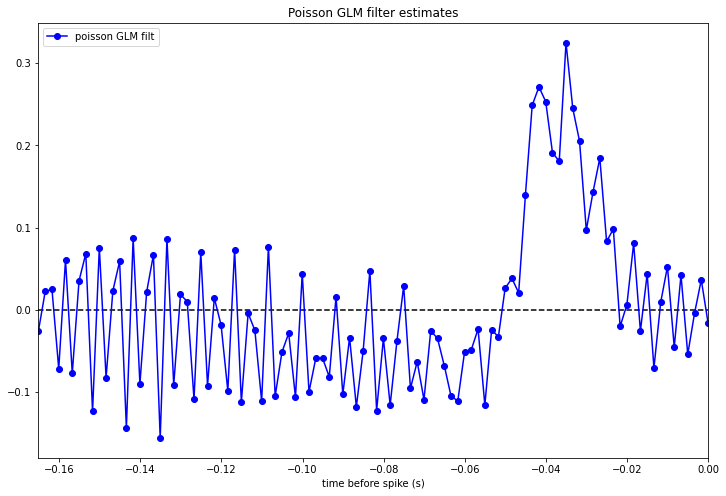

In [127]:
### ==== 3. Obtain stimulus filter =======

# For now, we will just obtain the filter from a model using only the stimulus
from scipy.linalg import hankel, inv, norm

ntfilt = 20 * upsamp_factor

# Construct design matrix
padded_stim = np.hstack((np.zeros(ntfilt-1), stim_train[:-ntfilt+1]))   # pad early bins of stimulus with zero
design_mat = np.hstack((np.ones((num_time_bins,1)), hankel(padded_stim, stim_train[-ntfilt:])))

# Package available for download from
# https://www.statsmodels.org/stable/install.html
import statsmodels.api as sm

### Fit GLM to get filter
glm_poisson_exp = sm.GLM(endog=spikes_binned_train, exog=design_mat,
                         family=sm.families.Poisson())

pGLM_results = glm_poisson_exp.fit(max_iter=100, tol=1e-6, tol_criterion='params')

pGLM_const = pGLM_results.params[0]
pGLM_filt = pGLM_results.params[1:] # stimulus filter

# Let's plot the filter
ttk = np.arange(-ntfilt+1,1)*dt_fine
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)
ax1.plot(ttk,ttk*0, 'k--')
ax1.plot(ttk, pGLM_filt/norm(pGLM_filt), 'o-', label='poisson GLM filt', c='b')
ax1.legend(loc = 'upper left')
ax1.set_title('Poisson GLM filter estimates')
ax1.set_xlabel('time before spike (s)')
ax1.set_xlim([ttk[0], ttk[-1]])

[-0.0262544   0.06060881 -0.00687541 -0.08960197  0.07020837 -0.07521972
  0.0872596   0.01532965 -0.11713428  0.07247194 -0.04269603  0.13396775
  0.01034697 -0.0333478   0.16284354  0.13807001  0.30594244  0.23807885
  0.16080049  0.34009534  0.40603518  0.53854928  0.29957779  0.31678907
  0.41978111  0.44947367  0.41230424  0.2318035   0.03446942  0.06350596
  0.04373586 -0.0542833  -0.04006191 -0.19188996 -0.03862434 -0.08013019
 -0.08487246 -0.18346137 -0.17378783 -0.11216759 -0.05755151 -0.0418289
 -0.18111432 -0.1043804  -0.15815179  0.04840957 -0.06321605 -0.19182939
 -0.05729474 -0.20285816  0.07845922 -0.08367972 -0.19519192 -0.05586164
 -0.1702907   0.02656012 -0.1349024  -0.09710551 -0.0978213  -0.16511283
  0.07314056 -0.17593053 -0.04705643 -0.08498135 -0.17383034  0.12705612
 -0.18395418 -0.04135486 -0.00676002 -0.18587484  0.12122908 -0.1631922
 -0.03026119  0.02396948 -0.15247929  0.11600855 -0.18037395  0.0165723
  0.03110165 -0.1514745   0.1434829  -0.25827555  0.11

<Figure size 432x288 with 0 Axes>

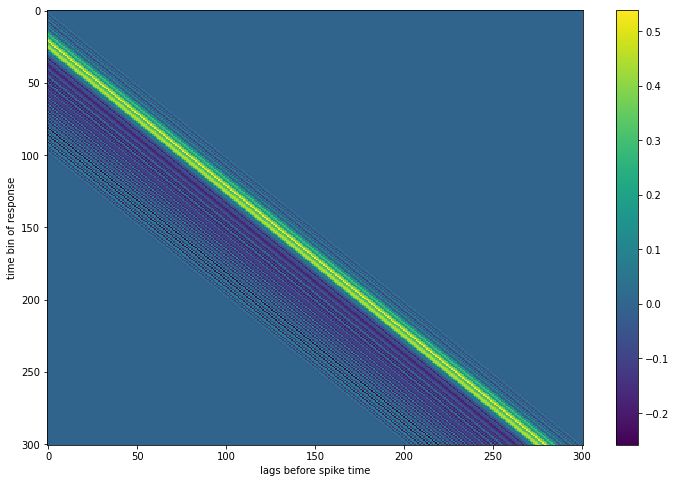

In [125]:
### ==== 4. Construct design matrix for MAP estimation ====

from scipy.linalg import toeplitz


# We will now solve for the stimulus that maximizes the posterior
# under a given model (filter). To do this we solve the same equation as before
# xk=y (where x is the stimulus, k is the filter, and y is the neural spikes)
# except now we are solving for x given the k plotted above. We also want to include
# a constant additive value that will contain the prediction for the early
# frames of the neuron, where the previous stimulus was included in training.

# So we need to make a design matrix out of our filter this time...
# Let's also assemble our held-out testing stimulus and binned spikes
# This matrix will be very large, so lets work with chunks of it at a time
num_test_bins = 10000

stim_test = stim_fine[num_time_bins:num_time_bins+num_test_bins] # only use some of the held out data
spikes_binned_test = spikes_binned[num_time_bins:num_time_bins+num_test_bins]

# The toeplitz operation constructs a matrix with constant digonals
# from the first column and first row
first_column = np.zeros(len(stim_test))
first_column[:ntfilt] = np.flip(pGLM_filt)
first_row = np.zeros(len(stim_test))
first_row[0] = pGLM_filt[-1]
print(first_column[:ntfilt+1])
Kdesign = toeplitz(first_column, first_row)

# Notice how the filter is a sliding window down the diagonal
# in each row, we are positioning the filter behind the spike we want to predict
plt.clf()
plt.figure(figsize=[12,8])
plt.imshow(Kdesign[:301,:301], aspect='auto', interpolation='nearest')
plt.xlabel('lags before spike time')
plt.ylabel('time bin of response')
plt.colorbar()
plt.show()

In [146]:
### ===== 4b. Remove known quantities about spikes =====

# For the spikes within the first ntfilt-1 of the beginning of the data
# We already know the stimulus that predicts them.
# We can account for this by creating a vector containing the known
# stimulus projected onto the parts of the filter missing from the early
# rows of the design matrix, then subtracting that out of the early spikes

# This represents that we are not actually solving xk=y for x, we are solving
# xk+c=y, where c is what we already know about each spike bin
# If we were to include spike-history, this c vector would also contain
# the spike-history predictions at each frame

known_stim = stim_fine[num_time_bins-(ntfilt-1):num_time_bins]

known_pred = np.zeros(ntfilt-1)
for bin_idx in np.arange(1, ntfilt-1):
    known_pred[bin_idx] = pGLM_filt[:-bin_idx] @ known_stim[bin_idx-1:]
    
# Now we can subtract out this known quantity from the spikes
spikes_binned_test = spikes_binned_test.astype(np.float64)
spikes_binned_test[:ntfilt-1] -= known_pred

In [ ]:
### Fit GLM to get stimulus
# import scipy.stat.pearsonr as pr
glm_stim = sm.GLM(endog=spikes_binned_test, exog=Kdesign,
                         family=sm.families.Binomial())

sGLM_results = glm_stim.fit(max_iter=7, tol=1e-6, tol_criterion='params')

sGLM_filt = pGLM_results.params # stimulus

print(sGLM_filt.shape)#, pr(sGLM_filt, stim_test))
plt.plot(stim_test[:200])
plt.plot(sGLM_filt[:200])

C:\Users\jcian\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\regression\_tools.py:121: RuntimeWarning: divide by zero encountered in double_scalars
  scale = np.dot(wresid, wresid) / df_resid
C:\Users\jcian\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\families\links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


In [147]:
### ===== 4.99 Create log-likelihood functions ===========
# Let's define some functions that calculates log-likelihood, gradient, and the hessian
# so we can pass them to scipy's automatic solver that will give us
# the optimized parameter fit using ML.

def neglogli_poissGLM(thetas, xx, yy, dt_bin, vals_to_return=3):
    """ Compute negative log-likelihood of data under Poisson GLM model with
        exponential nonlinearity.
        
        Args
        ----
        thetas: ndarray (d X 1)
            parameter vector
        xx: ndarray (T X d)
            design matrix
        yy: ndarray (T X 1)
            response variable (spike count per time bin)
        dt_bin: float
            time bin size used
        vals_to_return: int
            which of negative log-likelihood (0), gradient (1), or hessian (2) to return.
            3 returns all three values. This is necessary due to scipy.optimize.minimize
            requiring the three separate functions with a single return value for each.
            
        Returns
        -------
        neglogli: float
            negative log likelihood of spike train
        dL: ndarray (d X 1)
            gradient
        H: ndarray (d X d)
            Hessian (second derivative matrix)
    """
    
    # Compute GLM filter output and conditional intensity
    vv = xx @ thetas # filter output
    rr = np.exp(vv) * dt_bin # conditional intensity (per bin)

    # ---------  Compute log-likelihood -----------
    Trm1 = -vv.T @ yy; # spike term from Poisson log-likelihood
    Trm0 = np.sum(rr)  # non-spike term 
    neglogli = Trm1 + Trm0
    
    # ---------  Compute Gradient -----------------
    dL1 = -xx.T @ yy # spiking term (the spike-triggered average)
    dL0 = xx.T @ rr # non-spiking term
    dL = dL1 + dL0
    
    # ---------  Compute Hessian -------------------
    H = xx.T @ (xx * np.transpose([rr])) # non-spiking term
    
    if vals_to_return == 3:
        return neglogli, dL, H
    else:
        return [neglogli, dL, H][vals_to_return]

In [ ]:
### === 5. Fit poisson GLM using ML to find stimulus ====================

from scipy.optimize import minimize
# Compute maximum likelihood estimate (using 'fminunc' instead of 'glmfit')
sta = (design_mat_train.T @ binned_spikes_train)/np.sum(binned_spikes_train) # compute STA for initialization

# -- Make loss functions and minimize -----
loss_func = lambda prs : neglogli_poissGLM(prs, design_mat_train, binned_spikes_train, dt_fine, vals_to_return=0)
grad_func = lambda prs : neglogli_poissGLM(prs, design_mat_train, binned_spikes_train, dt_fine, vals_to_return=1)
hess_func = lambda prs : neglogli_poissGLM(prs, design_mat_train, binned_spikes_train, dt_fine, vals_to_return=2)
optimizer = minimize(fun=loss_func, x0=sta, method='trust-ncg', jac=grad_func, hess=hess_func, options={'disp':True, 'gtol':1e-6, 'maxiter': 7})
filt_ML = optimizer.x

ttk = np.arange(-ntfilt+1, 0)*dt_fine
fig = plt.figure(figsize=[12,8])
plt.plot(ttk, ttk*0, c='k', linestyle='--')
plt.plot(ttk, filt_ML[2:], c='darkorange', linewidth=4)
plt.xlabel('time before spike')
plt.ylabel('coefficient')
plt.title('Maximum likelihood filter estimate')
plt.tight_layout()
# plt.plot(ttk, sta[2:])
plt.show()

# Looks bad due to lack of regularization!